# Hierarchical LDA Demo

This notebook demonstrates how we can load the BBC Insight Dataset (http://mlg.ucd.ie/datasets/bbc.html), preprocess them via NLTK and run hierarchical LDA inference on the data. 

In [21]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
basedir = '../'
sys.path.append(basedir)

import pylab as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from hlda.sampler import HierarchicalLDA
from ipywidgets import widgets
from IPython.core.display import HTML, display

import string
import glob

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Load test corpus

Load and preprocess text using NLTK. Below we load all tech articles from the BBC Insight corpus.

In [2]:
stopset = stopwords.words('english') + list(string.punctuation) + ['will', 'also', 'said']

In [3]:
corpus = []
all_docs = []
vocab = set()

stemmer = PorterStemmer()
for filename in glob.glob('../bbc/tech/*.txt'):
    with open(filename) as f:
        try:
            
            doc = f.read().splitlines() 
            doc = filter(None, doc) # remove empty string
            doc = '. '.join(doc)
            doc = doc.translate(None, string.punctuation) # strip punctuations
            doc = doc.translate(None, '0123456789') # strip numbers        
            doc = doc.decode("utf8").encode('ascii', 'ignore') # ignore fancy unicode chars
            all_docs.append(doc)        

            tokens = word_tokenize(str(doc))
            filtered = []
            for w in tokens:
                w = stemmer.stem(w.lower()) # use Porter's stemmer
                if len(w) < 3:              # remove short tokens
                    continue
                if w in stopset:            # remove stop words
                    continue
                filtered.append(w)
                
            vocab.update(filtered)
            corpus.append(filtered)      
            
        except UnicodeDecodeError:
            print 'Failed to load', filename

Create an inverted index for the words to position in the sorted vocab

In [4]:
vocab = sorted(list(vocab))
vocab_index = {}
for i, w in enumerate(vocab):
    vocab_index[w] = i

Total number of documents in the corpus

In [5]:
print len(all_docs)

401


Total number of vocab. Also print the first 500 words in the sorted vocab.

In [6]:
print len(vocab)
print vocab[0:100]

8185
[u'aaa', 'aac', 'aadc', u'aarhu', 'aaron', u'abacu', u'abandon', u'abat', 'abbott', 'abensur', u'abet', u'abid', u'abil', u'abl', u'ablebodi', u'aboutroughli', u'abov', u'aboveaverag', 'abraham', u'abramovich', 'abroad', u'abruptli', u'absenc', u'absolut', u'absorb', 'abstain', 'abstract', 'abtahi', u'abund', u'abundantli', u'abus', u'academ', u'academi', 'academia', u'acceler', 'accept', u'access', u'accessori', u'accid', u'accident', 'acclaim', u'acclim', u'accolad', u'accommod', u'accompani', u'accomplic', u'accomplish', u'accord', u'accordingli', 'account', u'accumul', u'accur', u'accuraci', u'accus', u'achiev', 'acid', u'acknowledg', u'acquiesc', u'acquir', u'acquisit', u'acquit', u'acr', u'acrobat', u'across', 'act', 'action', 'actionfest', u'actionpack', u'activ', 'activcard', u'actor', 'actual', u'acut', 'adam', 'adamind', u'adapt', 'adaptor', u'adawar', u'add', u'addict', 'addin', u'addit', u'addon', u'address', 'adept', u'adequ', u'adher', u'adict', u'adida', u'adjudg', 

## 2. Visualise the data

Make some pretty word cloud using the Python Word Cloud package: https://github.com/amueller/word_cloud

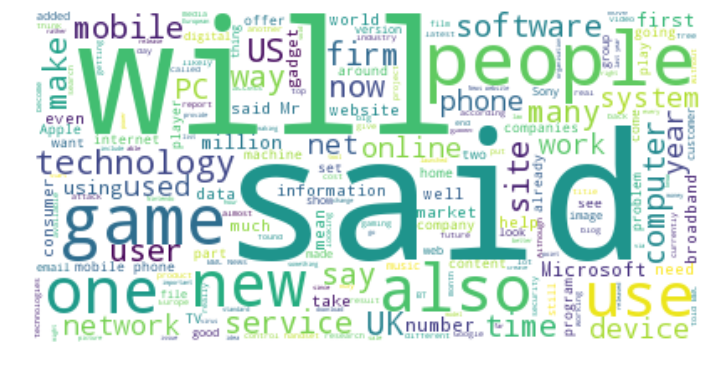

In [7]:
wordcloud = WordCloud(background_color='white').generate(' '.join(all_docs))
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## 3. Run hLDA

In [8]:
print len(vocab), len(corpus), len(corpus[0]), len(corpus[1])

8185 401 378 210


Convert words in the corpus into indices

In [9]:
new_corpus = []
for doc in corpus:
    new_doc = []
    for word in doc:
        word_idx = vocab_index[word]
        new_doc.append(word_idx)
    new_corpus.append(new_doc)

In [10]:
print len(vocab), len(new_corpus)
print corpus[0][0:10]
print new_corpus[0][0:10]

8185 401
['ink', u'help', 'drive', u'democraci', 'asia', 'kyrgyz', u'republ', 'small', u'mountain', 'state']
[3587, 3212, 2029, 1788, 401, 3928, 5974, 6595, 4609, 6831]


Create hierarchical LDA object and run the sampler.

In [11]:
n_samples = 500       # no of iterations for the sampler
alpha = 10.0          # smoothing over level distributions
gamma = 1.0           # CRP smoothing parameter; number of imaginary customers at next, as yet unused table
eta = 0.1             # smoothing over topic-word distributions
num_levels = 3        # the number of levels in the tree
display_topics = 50   # the number of iterations between printing a brief summary of the topics so far
n_words = 5           # the number of most probable words to print for each topic after model estimation
with_weights = False  # whether to print the words with the weights

In [12]:
hlda = HierarchicalLDA(new_corpus, vocab, alpha=alpha, gamma=gamma, eta=eta, num_levels=num_levels)
hlda.estimate(n_samples, display_topics=display_topics, n_words=n_words, with_weights=with_weights)

HierarchicalLDA sampling

.................................................. 50
topic=0 level=0 (documents=401): peopl, thi, use, technolog, get, 
    topic=1 level=1 (documents=148): user, mobil, network, servic, softwar, 
        topic=2 level=2 (documents=78): email, secur, viru, net, firm, 
        topic=3 level=2 (documents=53): appl, music, patent, mac, law, 
        topic=12 level=2 (documents=10): game, yahoo, learn, sim, educ, 
        topic=27 level=2 (documents=7): ink, print, elect, film, cinema, 
    topic=4 level=1 (documents=40): mobil, phone, top, game, like, 
        topic=5 level=2 (documents=10): radio, podcast, listen, hiphop, world, 
        topic=16 level=2 (documents=16): player, librari, blog, survey, american, 
        topic=23 level=2 (documents=14): game, award, play, titl, mobil, 
    topic=6 level=1 (documents=151): mobil, phone, use, music, peopl, 
        topic=7 level=2 (documents=30): site, attack, websit, traffic, data, 
        topic=8 level=2 (docume

## 4. Visualise results

In [22]:
colour_map = {
    0: 'blue',
    1: 'red',
    2: 'green'
}

def show_doc(d=0):
    
    node = hlda.document_leaves[d]
    path = []
    while node is not None:
        path.append(node)
        node = node.parent
    path.reverse()   
    
    n_words = 10
    with_weights = False    
    for n in range(len(path)):
        node = path[n]
        colour = colour_map[n] 
        msg = 'Level %d Topic %d: ' % (node.level, node.node_id)
        msg += node.get_top_words(n_words, with_weights)
        output = '<h%d><span style="color:%s">%s</span></h3>' % (n+1, colour, msg)
        display(HTML(output))
        
    display(HTML('<hr/><h5>Processed Document</h5>'))

    doc = corpus[d]
    output = ''
    for n in range(len(doc)):
        w = doc[n]
        l = hlda.levels[d][n]
        colour = colour_map[l]
        output += '<span style="color:%s">%s</span> ' % (colour, w)
    display(HTML(output))

If you run this notebook locally, you'd be able to flip through the documents in the corpus and see the topic assignments of individual words of the document.

In [23]:
widgets.interact(show_doc, d=(0, len(corpus)-1))

## 5. Dump the hlda object for further use later

https://stackoverflow.com/questions/18474791/decreasing-the-size-of-cpickle-objects

In [27]:
import cPickle
import gzip

def save_zipped_pickle(obj, filename, protocol=-1):
    with gzip.open(filename, 'wb') as f:
        cPickle.dump(obj, f, protocol)
        
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = cPickle.load(f)
        return loaded_object

In [28]:
save_zipped_pickle(hlda, 'bbc_hlda.p')